In [1]:
import itertools
import math
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Load Dataset

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # changed
])

train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

### Model

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=6, stride=2),
            nn.ReLU(),
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(288, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.conv(x)
        x  = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = x.view(x.size(0), -1)
        return x

In [5]:
# utils for dev
def output_dim_calc(h,kernel_sz,stride = 1,padding = 0,out_pad = 0):
    return (h-1) * stride - 2 * padding +  (kernel_sz - 1) + out_pad + 1
h = 5
h = output_dim_calc(h,3,1)
h = output_dim_calc(h,3,2)
h = output_dim_calc(h,3,2)
output_dim_calc(32,1,1,2)

28

In [6]:
# input noise dimension
latent_vector_sz = 25
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64
channel_num = 1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # nn.ConvTranspose2d(1,28*10,3,1,0,bias=False),
            # nn.BatchNorm2d(28*10),
            # nn.LeakyReLU(0.01,True),
            # nn.ConvTranspose2d(28*10,28*5,2,2,0,bias=False),
            # nn.BatchNorm2d(28*5),
            # nn.LeakyReLU(0.01,True),
            # nn.ConvTranspose2d(28*5,1,2,2,0,bias=False),
            # nn.Tanh()
            nn.ConvTranspose2d(latent_vector_sz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf,channel_num, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

In [7]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
# generator.load_state_dict(torch.load("model/mnist_gan_generator.pth"))
# discriminator.load_state_dict(torch.load("model/mnist_gan_discriminator.pth"))

### Optimization

In [8]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Training

In [9]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.unsqueeze(1).to(device)) # changed
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels.unsqueeze(1).to(device)) # changed
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [10]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.unsqueeze(1).to(device)) 
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [36]:
fig_epoch_counter = itertools.count()
def replot(images:torch.Tensor,g_lossi,d_lossi):
    num_test_samples = images.size(0)
    # create figure for plotting
    size_figure_grid = int(math.sqrt(num_test_samples))
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    epoch_n = next(fig_epoch_counter)
    plt.savefig(f'results/mnist-gan-{epoch_n}.png')
    plt.close()
    plt.title('MNIST GAN Loss')
    plt.plot(g_lossi,label="generator loss")
    plt.plot(d_lossi,label="discriminator loss")
    plt.legend()
    plt.show()
    plt.savefig(f'results/history/mnist_dcgan_loss_{epoch_n}.png')
    plt.close()

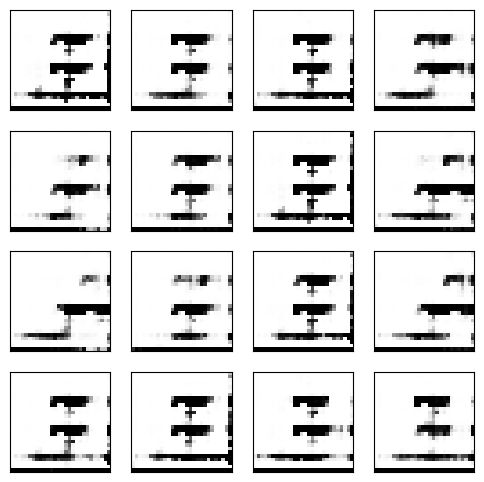

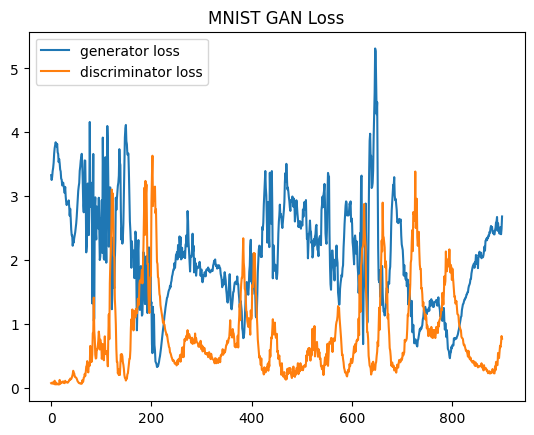

Epoch [2/200], Step[300/600],d_loss: 0.7669 g_loss: 2.680251359939575,D(X): 0.80, D(G(z)): 0.25
Saved PyTorch Model State to /model/


In [37]:
# set number of epochs and initialize figure counter
num_epochs = 200
num_batches = len(train_loader)
open('results/history/mnist_dcgan_generator_loss.csv','w+')
open('results/history/mnist_dcgan_discriminator_loss.csv','w+')
time_win_lim = 5000
d_lossi = []
g_lossi = []
for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = images.to(device)
        real_labels = torch.ones(images.size(0)).to(device)
        
        # Sample from generator
        noise = torch.randn(images.size(0), latent_vector_sz,1,1).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(images.size(0)).to(device)
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        d_lossi.append(d_loss.item())
        d_lossi = d_lossi[:time_win_lim]
        with open('results/history/mnist_dcgan_discriminator_loss.csv','a') as f:
            f.write(f"{d_loss}\n")
            
        # Sample again from the generator and get output from discriminator
        noise = torch.randn(images.size(0), latent_vector_sz,1,1).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        with open('results/history/mnist_dcgan_generator_loss.csv','a') as f:
            f.write(f"{g_loss}\n")
        g_lossi.append(g_loss.item())
        g_lossi = g_lossi[:time_win_lim]
        
        if (n+1) % 100 == 0:
            # draw samples from the input distribution to inspect the generation on training 
            num_test_samples = 16
            test_noise = torch.randn(num_test_samples, latent_vector_sz,1,1).to(device)
            test_images = generator(test_noise)
            replot(test_images.cpu(),g_lossi,d_lossi)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Step[{n+1}/{num_batches}],'
                  f'd_loss: {d_loss.data.item():.4f} g_loss: {g_loss.data.item()},'
                  f'D(X): {real_score.data.mean():.2f}, D(G(z)): {fake_score.data.mean():.2f}')

            # save param
            torch.save(generator.state_dict(), "model/mnist_gan_generator.pth")
            torch.save(discriminator.state_dict(), "model/mnist_gan_discriminator.pth")
            print("Saved PyTorch Model State to /model/")
